In [1]:
# Stock Price Prediction - Feature Analysis for RNN Sequence Selection
# Analyzing features to determine optimal sequence length for LSTM/GRU models

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 10

print("="*80)
print("STOCK PRICE PREDICTION - FEATURE ANALYSIS")
print("="*80)
print("\nObjective: Determine optimal sequence length for RNN input")
print("Target: Predict if close price > current price after 30 trading days")
print("="*80)

STOCK PRICE PREDICTION - FEATURE ANALYSIS

Objective: Determine optimal sequence length for RNN input
Target: Predict if close price > current price after 30 trading days


In [17]:

# ============================================================================
# SECTION 1: DATA LOADING AND INITIAL PREPROCESSING
# ============================================================================

print("\n[1] LOADING DATA...")
# Load the dataset
df = pd.read_csv(r'D:\Projects\4-th year\neural networks\stock-trend-prediction\data\raw\train.csv')

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'])
df = df[df['Open'] != 0]

# Sort by Ticker and Date
df = df.sort_values(['Ticker', 'Date']).reset_index(drop=True)

print(f"Total records: {len(df):,}")
print(f"Unique tickers: {df['Ticker'].nunique():,}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"\nMemory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Display basic statistics
print("\n" + "="*80)
print("DATA OVERVIEW")
print("="*80)
print(df.head())
print("\nData types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())


[1] LOADING DATA...
Total records: 20,225,745
Unique tickers: 5,000
Date range: 1962-01-02 00:00:00 to 2024-09-23 00:00:00

Memory usage: 2381.96 MB

DATA OVERVIEW
     Ticker       Date      Open      High       Low     Close    Volume  \
0  ticker_1 1970-01-02  0.234204  0.246771  0.234204  0.246771   73200.0   
1  ticker_1 1970-01-05  0.249056  0.257053  0.249056  0.257053  130800.0   
2  ticker_1 1970-01-06  0.257053  0.261623  0.249056  0.253626  312400.0   
3  ticker_1 1970-01-07  0.252484  0.252484  0.249056  0.250199   51600.0   
4  ticker_1 1970-01-08  0.250199  0.253626  0.249056  0.250199   79200.0   

   Dividends  Stock Splits  
0        0.0           0.0  
1        0.0           0.0  
2        0.0           0.0  
3        0.0           0.0  
4        0.0           0.0  

Data types:
Ticker                  object
Date            datetime64[ns]
Open                   float64
High                   float64
Low                    float64
Close                  float64
Volum

In [18]:
def find_unset_values(df):
    result = {}

    result['null'] = df['Open'].isnull().sum()
    result['zeros'] = (df['Open'] == 0).sum()
    result['infinite'] = np.isinf(df['Open']).sum()
    return pd.DataFrame([result])

find_unset_values(df)

,null,zeros,infinite
0,0,0,0


In [19]:

# ============================================================================
# SECTION 2: FEATURE ENGINEERING
# ============================================================================

print("\n" + "="*80)
print("[2] ENGINEERING FEATURES...")
print("="*80)

def engineer_features(df):
    """
    Create all derived features for analysis
    """
    df = df.copy()

    # Sort to ensure proper calculation
    df = df.sort_values(['Ticker', 'Date']).reset_index(drop=True)

    # Group by ticker for calculations
    grouped = df.groupby('Ticker')

    print("\nCalculating features:")

    # 1. Daily Return: (Close - Open) / Open
    print("  - daily_return")
    df['daily_return'] = (df['Close'] - df['Open']) / df['Open']

    # 2. High-Low Ratio: (High - Low) / Close
    print("  - high_low_ratio")
    df['high_low_ratio'] = (df['High'] - df['Low']) / df['Close']

    # 3. Return 30 days: (Close_t - Close_t-30) / Close_t-30
    print("  - return_30")
    df['close_30d_ago'] = grouped['Close'].shift(30)
    df['return_30'] = (df['Close'] - df['close_30d_ago']) / df['close_30d_ago']

    # 4-6. Moving Averages
    print("  - MA_5, MA_10, MA_30")
    df['MA_5'] = grouped['Close'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
    df['MA_10'] = grouped['Close'].transform(lambda x: x.rolling(window=10, min_periods=1).mean())
    df['MA_30'] = grouped['Close'].transform(lambda x: x.rolling(window=30, min_periods=1).mean())

    # 7. Standard Deviation 10 days
    print("  - STD_10")
    df['STD_10'] = grouped['Close'].transform(lambda x: x.rolling(window=10, min_periods=1).std())

    # 8. Log Volume
    print("  - log_volume")
    df['log_volume'] = np.log(df['Volume'] + 1)

    # 9. Volume Ratio: Volume / Rolling Mean Volume (10 days)
    print("  - volume_ratio")
    df['volume_ma_10'] = grouped['Volume'].transform(lambda x: x.rolling(window=10, min_periods=1).mean())
    df['volume_ratio'] = df['Volume'] / df['volume_ma_10']

    # 10. Dividend Yield
    print("  - dividend_yield")
    df['dividend_yield'] = df['Dividends'] / df['Close']

    # 11. Days since last split
    print("  - has_split")
    df['has_split'] = (df['Stock Splits'] > 0).astype(int)


    # Create target variable: Will price be higher in 30 days?
    print("  - target (price > current after 30 days)")
    df['close_30d_future'] = grouped['Close'].shift(-30)
    df['target'] = (df['close_30d_future'] > df['Close']).astype(int)

    # Drop temporary columns
    df = df.drop(['close_30d_ago', 'volume_ma_10', 'has_split', 'close_30d_future'], axis=1)

    return df

# Apply feature engineering
df_features = engineer_features(df)

print("\n✓ Feature engineering complete!")
print(f"Total features created: 11")
print(f"Rows with complete features: {df_features.dropna().shape[0]:,}")


[2] ENGINEERING FEATURES...

Calculating features:
  - daily_return
  - high_low_ratio
  - return_30
  - MA_5, MA_10, MA_30
  - STD_10
  - log_volume
  - volume_ratio
  - dividend_yield
  - has_split
  - target (price > current after 30 days)

✓ Feature engineering complete!
Total features created: 11
Rows with complete features: 19,951,739



[3] DATA QUALITY ANALYSIS

Missing values in engineered features:
                Missing_Count  Missing_Percentage
daily_return                0                0.00
high_low_ratio              0                0.00
return_30              150000                0.74
MA_5                        0                0.00
MA_10                       0                0.00
MA_30                       0                0.00
STD_10                   5000                0.02
log_volume                  0                0.00
volume_ratio           133289                0.66
dividend_yield              0                0.00

FEATURE STATISTICS
       daily_return  high_low_ratio     return_30          MA_5         MA_10  \
count  2.022574e+07    2.022574e+07  2.007574e+07  2.022574e+07  2.022574e+07   
mean   4.077354e-04    3.377121e-02  1.890133e-02  2.375036e+01  2.374138e+01   
std    4.284201e-01    4.044551e-02  4.594674e-01  3.441371e+01  3.438420e+01   
min   -9.294927e-01    0.000000e+00 -9.

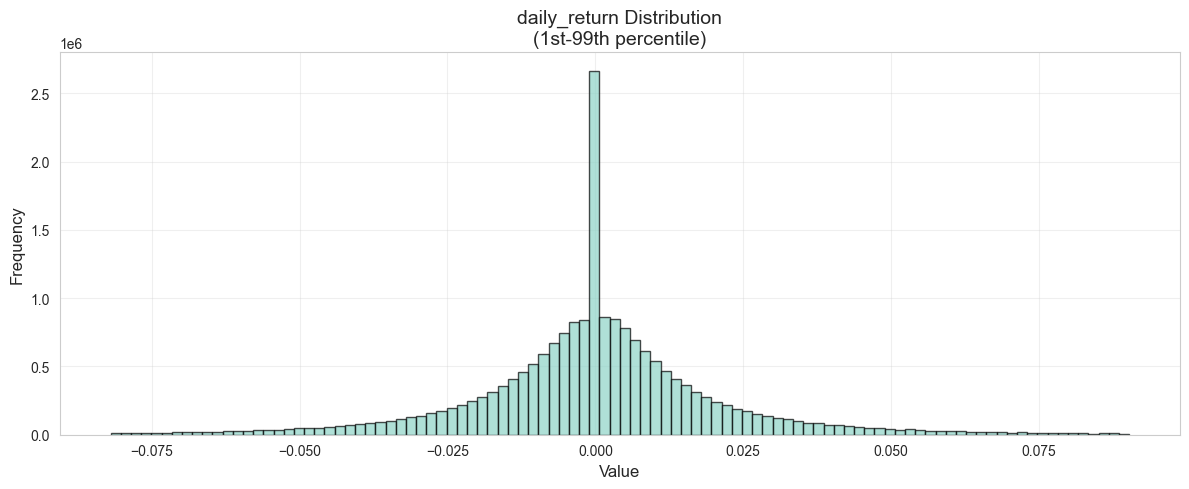

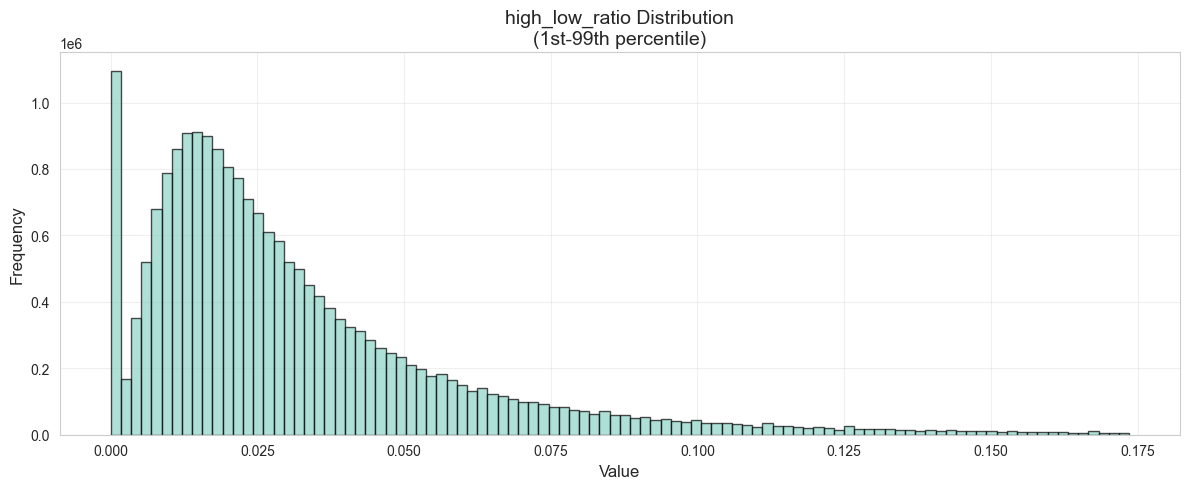

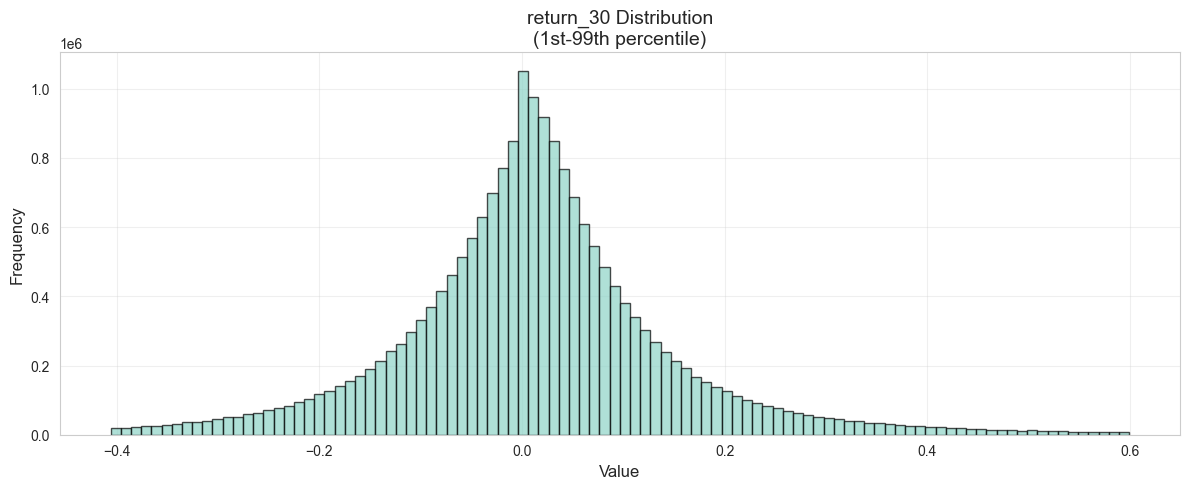

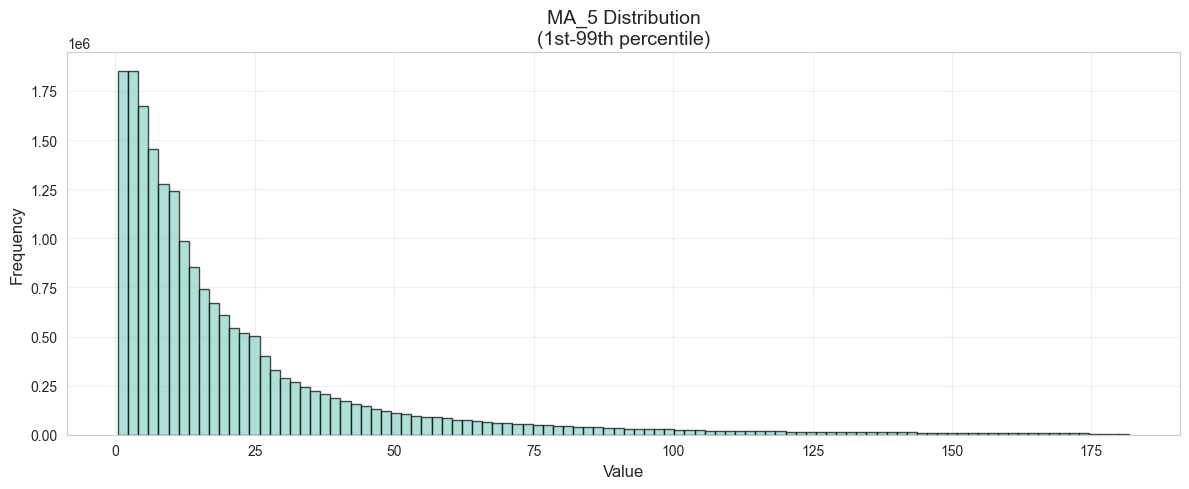

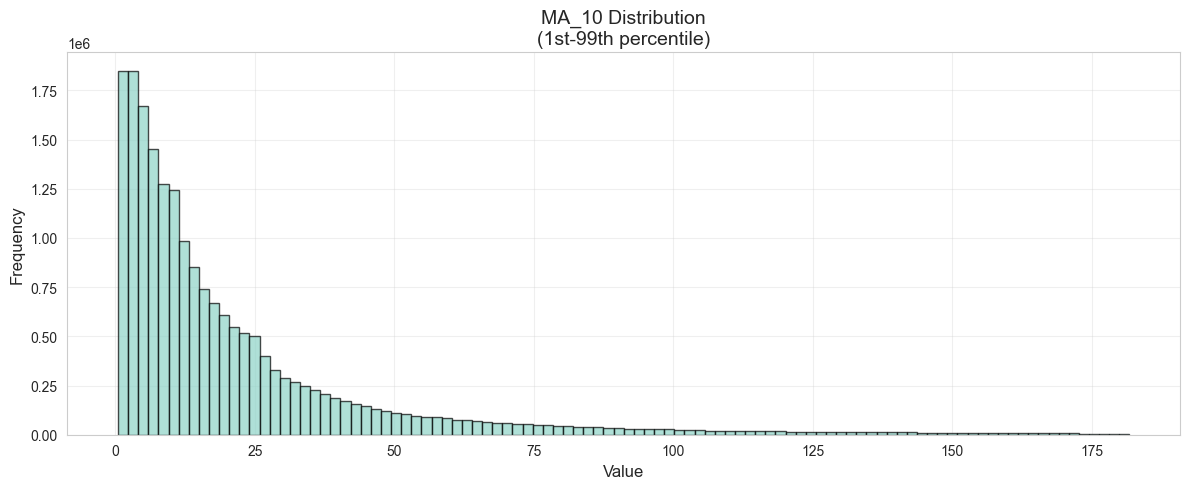

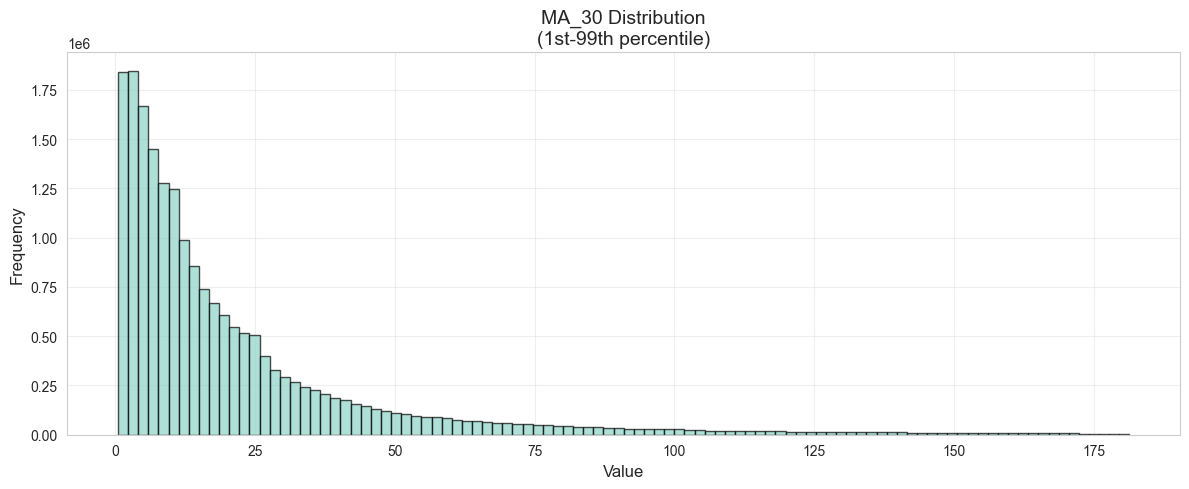

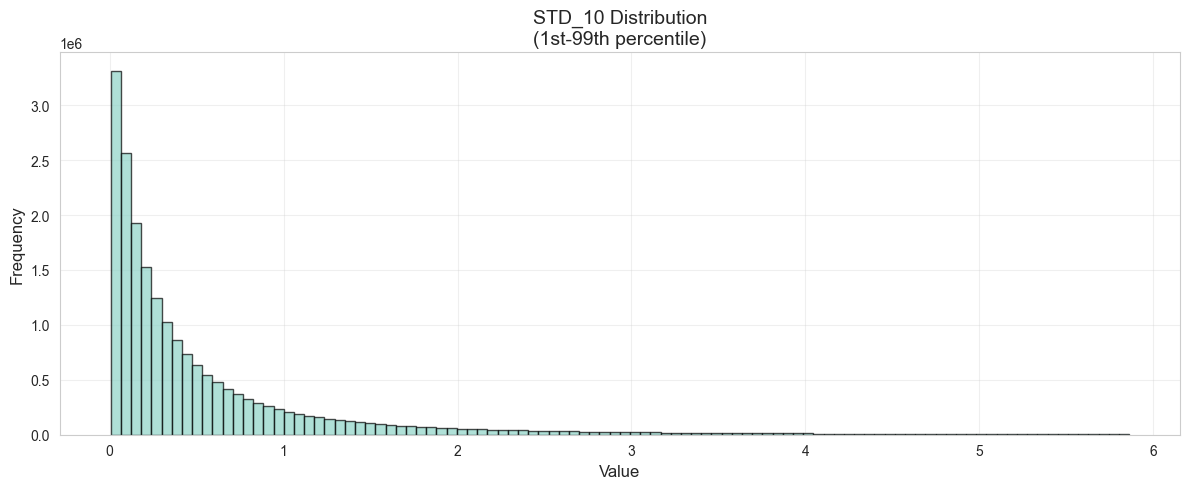

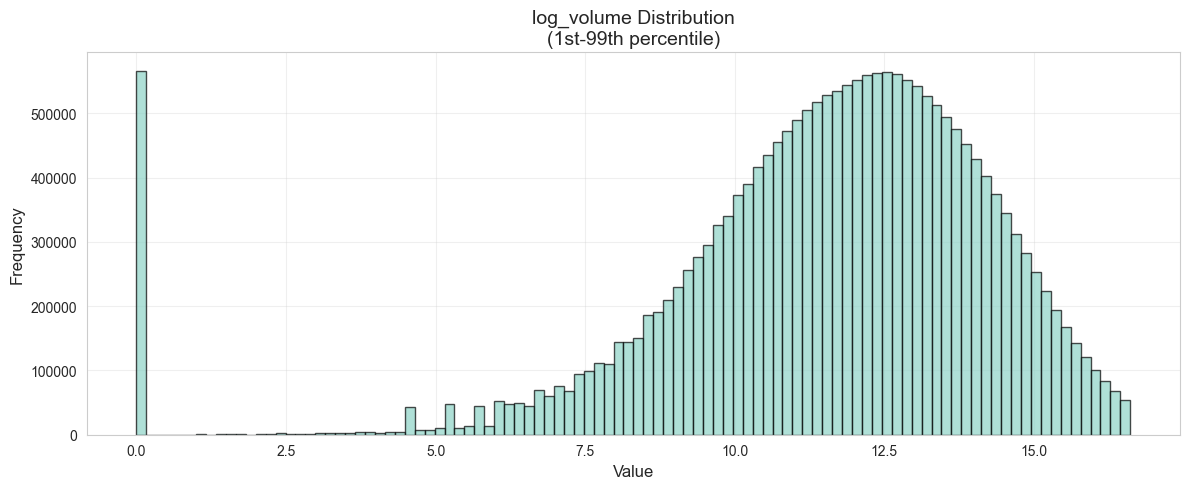

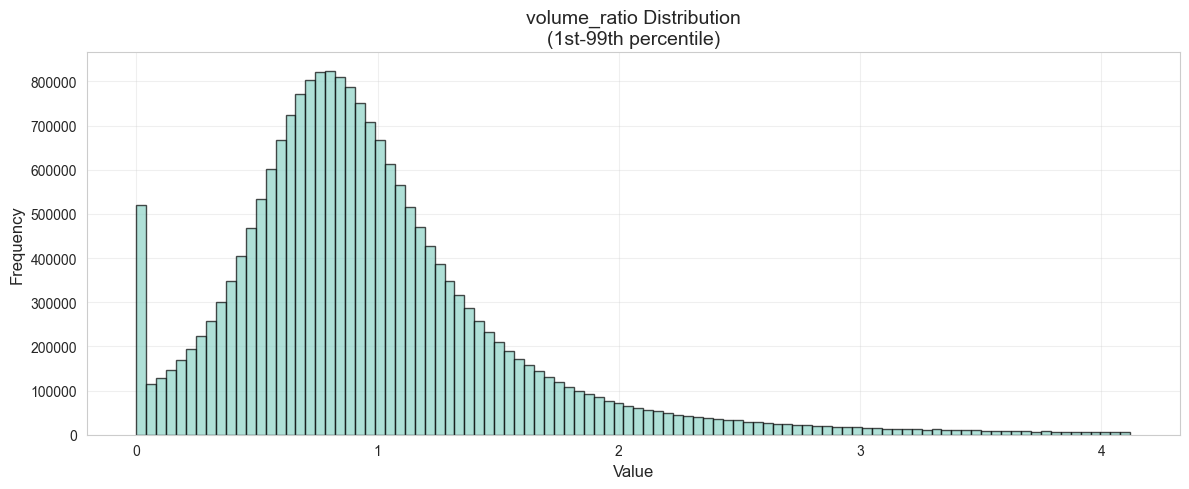

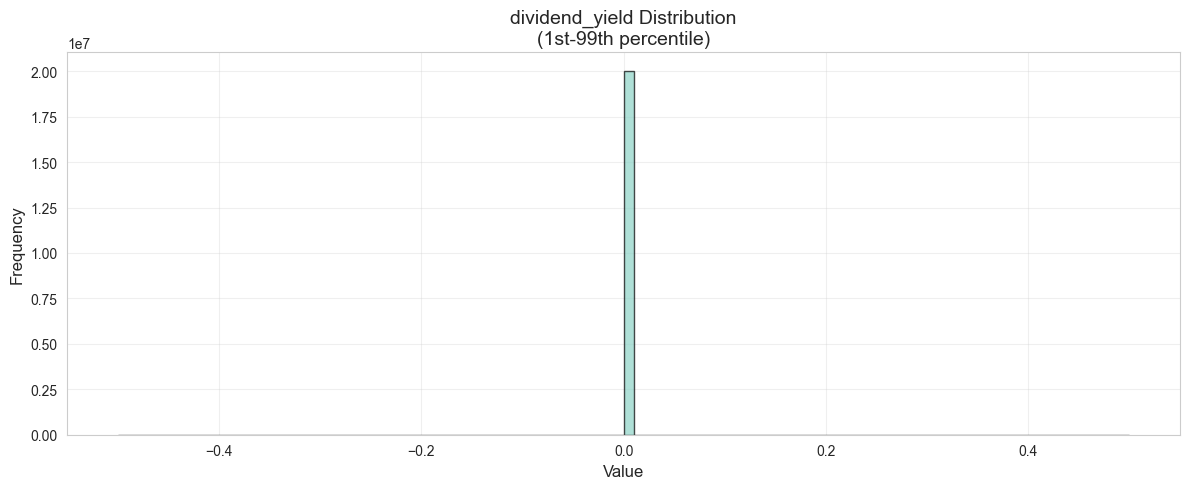

In [22]:

# ============================================================================
# SECTION 3: DATA QUALITY ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("[3] DATA QUALITY ANALYSIS")
print("="*80)

# List of engineered features
feature_columns = [
    'daily_return', 'high_low_ratio', 'return_30',
    'MA_5', 'MA_10', 'MA_30', 'STD_10',
    'log_volume', 'volume_ratio', 'dividend_yield'
]

# Check missing values
print("\nMissing values in engineered features:")
missing_stats = df_features[feature_columns].isnull().sum()
missing_pct = (missing_stats / len(df_features) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing_Count': missing_stats,
    'Missing_Percentage': missing_pct
})
print(missing_df)

# Basic statistics
print("\n" + "="*80)
print("FEATURE STATISTICS")
print("="*80)
print(df_features[feature_columns].describe())

# Visualization: Distribution of features
for feature in feature_columns:
    data = df_features[feature].dropna()

    # Remove extreme outliers for better visualization (keep 1st-99th percentile)
    q1, q99 = data.quantile([0.01, 0.99])
    data_filtered = data[(data >= q1) & (data <= q99)]

    plt.figure(figsize=(12, 5))  # wider figure
    plt.hist(data_filtered, bins=100, edgecolor='black', alpha=0.7)
    plt.title(f'{feature} Distribution\n(1st-99th percentile)', fontsize=14)
    plt.xlabel('Value', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'feature_{feature}.png', dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
# ============================================================================
# SECTION 4: AUTOCORRELATION ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("[4] AUTOCORRELATION ANALYSIS")
print("="*80)
print("Analyzing how each feature correlates with its past values")
print("This helps determine optimal sequence length for RNN")

# Sample data for faster computation (use 500k records)
sample_size = min(500000, len(df_features))
df_sample = df_features.dropna(subset=feature_columns).sample(n=sample_size, random_state=42)

max_lags = 60  # Analyze up to 60 days lag

autocorr_results = {}

for feature in feature_columns:
    print(f"\nAnalyzing autocorrelation: {feature}")

    # Calculate autocorrelation
    data = df_sample[feature].dropna()
    autocorr_values = acf(data, nlags=max_lags, fft=True)

    # Store results
    autocorr_results[feature] = autocorr_values

    # Plot (single plot per feature)
    plt.figure(figsize=(8, 5))
    lags = np.arange(len(autocorr_values))
    plt.bar(lags, autocorr_values, width=0.8, alpha=0.7)
    plt.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    plt.axhline(y=0.05, color='red', linestyle='--', linewidth=1, label='Threshold (0.05)')
    plt.axhline(y=-0.05, color='red', linestyle='--', linewidth=1)
    plt.title(f'Autocorrelation: {feature}', fontsize=11, fontweight='bold')
    plt.xlabel('Lag (days)')
    plt.ylabel('Autocorrelation')
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'autocorrelation_{feature}.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Find optimal lag (where autocorr drops below threshold)
    threshold = 0.05
    significant_lags = np.where(np.abs(autocorr_values) > threshold)[0]
    if len(significant_lags) > 1:
        optimal_lag = significant_lags[-1]
        print(f"  Optimal lag: {optimal_lag} days (autocorr = {autocorr_values[optimal_lag]:.4f})")
    else:
        print(f"  Low autocorrelation (independent)")

# Summary table of autocorrelation decay
print("\n" + "="*80)
print("AUTOCORRELATION DECAY SUMMARY")
print("="*80)

decay_summary = []
for feature, autocorr_vals in autocorr_results.items():
    # Find lag where autocorr first drops below 0.05
    below_threshold = np.where(np.abs(autocorr_vals[1:]) < 0.05)[0]
    if len(below_threshold) > 0:
        decay_lag = below_threshold[0] + 1
    else:
        decay_lag = max_lags

    decay_summary.append({
        'Feature': feature,
        'Lag_10': autocorr_vals[10],
        'Lag_20': autocorr_vals[20],
        'Lag_30': autocorr_vals[30],
        'Decay_Point': decay_lag
    })

decay_df = pd.DataFrame(decay_summary)
print(decay_df.to_string(index=False))


In [ ]:

# ============================================================================
# SECTION 5: TARGET-LAG CORRELATION ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("[5] TARGET-LAG CORRELATION ANALYSIS")
print("="*80)
print("Analyzing correlation between lagged features and target variable")

# Calculate target-lag correlations
target_lag_results = {}

fig, axes = plt.subplots(4, 3, figsize=(18, 16))
axes = axes.flatten()

for idx, feature in enumerate(feature_columns):
    print(f"\nAnalyzing target correlation: {feature}")

    correlations = []
    lags = range(1, max_lags + 1)

    # Sample ticker for analysis
    sample_ticker = df_features['Ticker'].iloc[0]
    ticker_data = df_features[df_features['Ticker'] == sample_ticker].copy()
    ticker_data = ticker_data.sort_values('Date').reset_index(drop=True)

    for lag in lags:
        lagged_feature = ticker_data[feature].shift(lag)
        valid_mask = ticker_data['target'].notna() & lagged_feature.notna()

        if valid_mask.sum() > 30:  # Need at least 30 samples
            corr = ticker_data.loc[valid_mask, 'target'].corr(lagged_feature[valid_mask])
            correlations.append(corr)
        else:
            correlations.append(0)

    target_lag_results[feature] = correlations

    # Plot
    axes[idx].plot(lags, correlations, marker='o', markersize=3, linewidth=1.5)
    axes[idx].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    axes[idx].axhline(y=0.05, color='red', linestyle='--', linewidth=1, alpha=0.5)
    axes[idx].axhline(y=-0.05, color='red', linestyle='--', linewidth=1, alpha=0.5)
    axes[idx].set_title(f'Target Correlation: {feature}', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Lag (days)')
    axes[idx].set_ylabel('Correlation with Target')
    axes[idx].grid(True, alpha=0.3)

    # Find peak correlation
    max_corr_idx = np.argmax(np.abs(correlations))
    max_corr = correlations[max_corr_idx]
    print(f"  Peak correlation: {max_corr:.4f} at lag {max_corr_idx + 1}")

axes[-1].remove()

plt.tight_layout()
plt.savefig('03_target_lag_correlation.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: 03_target_lag_correlation.png")
plt.show()

In [ ]:

# ============================================================================
# SECTION 6: ROLLING STATISTICS ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("[6] ROLLING STATISTICS ANALYSIS")
print("="*80)
print("Analyzing stability of features across different window sizes")

# Calculate rolling mean and std for different windows
windows = [5, 10, 15, 20, 30, 45, 60]

rolling_stats_results = {feature: {'windows': [], 'mean_std': [], 'std_std': []}
                         for feature in feature_columns}

# Sample one ticker for analysis
sample_ticker_data = df_features[df_features['Ticker'] == df_features['Ticker'].iloc[0]].copy()
sample_ticker_data = sample_ticker_data.sort_values('Date').reset_index(drop=True)

for feature in feature_columns:
    print(f"Analyzing rolling stats: {feature}")

    for window in windows:
        rolling_mean = sample_ticker_data[feature].rolling(window=window).mean()
        rolling_std = sample_ticker_data[feature].rolling(window=window).std()

        # Calculate stability (std of rolling mean)
        mean_stability = rolling_mean.std()
        std_stability = rolling_std.std()

        rolling_stats_results[feature]['windows'].append(window)
        rolling_stats_results[feature]['mean_std'].append(mean_stability)
        rolling_stats_results[feature]['std_std'].append(std_stability)

# Plot rolling statistics
fig, axes = plt.subplots(4, 3, figsize=(18, 16))
axes = axes.flatten()

for idx, feature in enumerate(feature_columns):
    ax = axes[idx]

    windows_list = rolling_stats_results[feature]['windows']
    mean_std_list = rolling_stats_results[feature]['mean_std']
    std_std_list = rolling_stats_results[feature]['std_std']

    ax2 = ax.twinx()

    line1 = ax.plot(windows_list, mean_std_list, 'b-o', label='Rolling Mean Std', linewidth=2)
    line2 = ax2.plot(windows_list, std_std_list, 'r-s', label='Rolling Std Std', linewidth=2)

    ax.set_xlabel('Window Size (days)')
    ax.set_ylabel('Std of Rolling Mean', color='b')
    ax2.set_ylabel('Std of Rolling Std', color='r')
    ax.set_title(f'Rolling Statistics: {feature}', fontsize=11, fontweight='bold')
    ax.tick_params(axis='y', labelcolor='b')
    ax2.tick_params(axis='y', labelcolor='r')
    ax.grid(True, alpha=0.3)

    # Combine legends
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc='upper right', fontsize=8)

axes[-1].remove()

plt.tight_layout()
plt.savefig('04_rolling_statistics.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: 04_rolling_statistics.png")
plt.show()

In [ ]:

# ============================================================================
# SECTION 7: FEATURE CORRELATION HEATMAP
# ============================================================================

print("\n" + "="*80)
print("[7] FEATURE CORRELATION ANALYSIS")
print("="*80)

# Calculate correlation matrix
corr_sample = df_features[feature_columns + ['target']].dropna().sample(n=min(100000, len(df_features)), random_state=42)
correlation_matrix = corr_sample.corr()

# Plot heatmap
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.3f',
            cmap='coolwarm', center=0, square=True, linewidths=1,
            cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('05_correlation_heatmap.png', dpi=300, bbox_inches='tight')
print("✓ Saved: 05_correlation_heatmap.png")
plt.show()

# Print high correlations with target
print("\nCorrelations with Target (sorted by absolute value):")
target_corr = correlation_matrix['target'].drop('target').sort_values(key=abs, ascending=False)
print(target_corr)

In [ ]:

# ============================================================================
# SECTION 8: RECOMMENDATIONS AND SUMMARY
# ============================================================================

print("\n" + "="*80)
print("[8] RECOMMENDATIONS FOR RNN SEQUENCE LENGTH")
print("="*80)

# Analyze autocorrelation decay to recommend sequence length
avg_decay_point = decay_df['Decay_Point'].mean()
recommended_seq_min = int(avg_decay_point * 0.7)
recommended_seq_optimal = int(avg_decay_point)
recommended_seq_max = int(avg_decay_point * 1.3)

print(f"\nBased on autocorrelation analysis:")
print(f"  • Average autocorrelation decay point: {avg_decay_point:.1f} days")
print(f"  • Recommended minimum sequence length: {recommended_seq_min} days")
print(f"  • Recommended optimal sequence length: {recommended_seq_optimal} days")
print(f"  • Recommended maximum sequence length: {recommended_seq_max} days")

print("\n" + "-"*80)
print("KEY INSIGHTS:")
print("-"*80)

# Find features with strongest autocorrelation
strong_autocorr = decay_df.nlargest(3, 'Lag_30')['Feature'].tolist()
print(f"\n1. Features with strongest temporal dependencies:")
for feat in strong_autocorr:
    print(f"   • {feat}")

# Find features most correlated with target
strong_target = target_corr.head(3)
print(f"\n2. Features most correlated with target:")
for feat, corr in strong_target.items():
    print(f"   • {feat}: {corr:.4f}")

# Identify potential issues
print(f"\n3. ⚠️  WARNINGS:")

# Check return_30
if 'return_30' in feature_columns:
    print(f"   • return_30: POTENTIAL DATA LEAKAGE!")
    print(f"     This feature uses close price from 30 days ago,")
    print(f"     which overlaps with your 30-day prediction target.")
    print(f"     Recommendation: Use return_20 or return_15 instead.")

# Check dividend_yield sparsity
div_nonzero = (df_features['dividend_yield'] > 0).sum()
div_pct = div_nonzero / len(df_features) * 100
print(f"   • dividend_yield: {div_pct:.2f}% non-zero values (very sparse)")
if div_pct < 1:
    print(f"     Recommendation: Consider removing or separate treatment")

# Check day_since_last_split sparsity
split_occurred = (df_features['day_since_last_split'] < 999).sum()
split_pct = split_occurred / len(df_features) * 100
print(f"   • day_since_last_split: Only {split_pct:.2f}% of stocks have splits")
print(f"     Recommendation: Consider removing this feature")

print("\n" + "-"*80)
print("FINAL RECOMMENDATIONS:")
print("-"*80)
print(f"""
1. SEQUENCE LENGTH:
   Use {recommended_seq_optimal} days as your RNN input sequence length
   (Range: {recommended_seq_min}-{recommended_seq_max} days for experimentation)

2. CRITICAL FEATURES (include in model):
   {', '.join(strong_autocorr[:5])}

3. FEATURES TO MODIFY:
   • Replace 'return_30' with 'return_20' or 'return_15'
   • Consider removing 'dividend_yield' and 'day_since_last_split'

4. MODEL ARCHITECTURE SUGGESTIONS:
   • Use LSTM or GRU layers
   • Input shape: (batch_size, {recommended_seq_optimal}, num_features)
   • Consider bidirectional layers for better temporal modeling
   • Use dropout (0.2-0.3) to prevent overfitting

5. PREPROCESSING:
   • Normalize/standardize features per ticker
   • Handle missing values with forward fill (within ticker)
   • Remove first 30 days per ticker (insufficient history)
""")

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print("\nGenerated files:")
print("  • 01_feature_distributions.png")
print("  • 02_autocorrelation_analysis.png")
print("  • 03_target_lag_correlation.png")
print("  • 04_rolling_statistics.png")
print("  • 05_correlation_heatmap.png")
print("\n" + "="*80)